 # Model-based (using Reddit Comments)

In [15]:
from system import *
from agents import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
import pandas as pd
import random
import math
from tqdm import tqdm

In [16]:
STATE_DIM = len(TradingEnv().reset())
#     print(f"STATE_DIM = {STATE_DIM}")
EMBED_DIM = 50  # from the dimensionality-reduced fastText model
HIDDEN_LAYER = 70  # NN hidden layer size
ACTION_DIM = 3

# EPISODES = 2000  # number of episodes
# EPS_START = 0.9  # e-greedy threshold start value
# EPS_END = 0.05  # e-greedy threshold end value
# EPS_DECAY = 200  # e-greedy threshold decay
# # GAMMA = 0.99  # Q-learning discount factor
# LR = 0.001  # NN optimizer learning rate
# HIDDEN_LAYER = 128  # NN hidden layer size
# BATCH_SIZE = 16  # Q-learning batch size
# TARGET_UPDATE = 100  # frequency of target update
BUFFER_SIZE = 256  # capacity of the replay buffer

# if gpu is to be used
# use_cuda = torch.cuda.is_available()
use_cuda = True
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

In [17]:
class RewardModel(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1_text  = nn.Linear(EMBED_DIM, HIDDEN_LAYER)
        self.l1_state = nn.Linear(STATE_DIM, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, ACTION_DIM)

    def forward(self, state, text, logits=True):
        """
            returns the expected future reward for taking each action
        """
        assert not torch.isnan(state).any(), f"NaN in input state {state}"
        assert not torch.isnan(text).any(), f"NaN in input embedding {text}"
        h_state = F.relu(self.l1_state(state))
        h_text  = F.relu(self.l1_text(text))
#         h = torch.cat([h_state, h_text], dim=1)
        h = h_state + h_text
        r = self.l2(h)
        
        return r

    def sample_from_softmax_policy(self, batch_state, batch_text):
        batch_logits = self.forward(batch_state, batch_text).detach()
        assert not torch.isnan(batch_logits).any(), f"NaN in policy logits {batch_logits}"
        batch_size = batch_logits.shape[0]
        actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            logits = batch_logits[i, :]
            dist = torch.distributions.Categorical(logits=logits)
            actions[i, 0] = dist.sample().view(1, 1)
        if use_cuda:
            actions = actions.to(batch_state.get_device())
        return actions.long()

class QWithTextModel(RewardModel):
    def __init__(self):
        RewardModel.__init__(self)


In [18]:
# m = RewardModel()
# state_tensor = FloatTensor([state])
# text_tensor  = FloatTensor(text)
# text_tensor = text_tensor.mean(dim=0, keepdim=True)
# m(state_tensor, text_tensor)

In [19]:
# m = QWithTextModel()
# state_tensor = FloatTensor([state])
# text_tensor  = FloatTensor(text)
# text_tensor = text_tensor.mean(dim=0, keepdim=True)
# m(state_tensor, text_tensor)

In [20]:
# # a = torch.randn(50, 80)
# # print(a.shape)
# # b = torch.split(a, 40, dim=1)

# seq_tensors = torch.split(state_tensor, 5, dim=1)
# n = torch.zeros((1, 5))
# # (seq_tensors[0].shape)

In [21]:
# torch.cat((*seq_tensors[1:], n))

In [22]:
class TransitionModel(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)

        self.sequence_length = 14
        self.x_dim = 5
        self.A = nn.Linear(STATE_DIM, self.x_dim)
        
    def forward(self, state):
        y = self.A(state)
        return y
    
    def next_state(self, state):
        y = self.forward(state)
        sequence = torch.split(state, self.x_dim, dim=1)
        new_state = torch.cat((*sequence[1:], y), dim=1)
        return new_state

# T = TransitionModel()
# T(state_tensor), T.next_state(state_tensor)

In [53]:
class ModelBasedAgent(BaseAgent):
    LR = 0.001  # NN optimizer learning rate
    BATCH_SIZE = 16  # Q-learning batch size
    TARGET_UPDATE = 100  # frequency of target update
    BUFFER_SIZE = 256  # capacity of the replay buffer

    def __init__(self):
        super().__init__()
        self.name = "Model-based"
        self.R = RewardModel()
        self.T = TransitionModel()
        self.Q = QWithTextModel()
        
        if use_cuda:
            self.R.cuda()
            self.T.cuda()
            self.Q.cuda()
        
        self.R_opt = optim.Adam(self.R.parameters())
        self.T_opt = optim.Adam(self.T.parameters())
        self.Q_opt = optim.Adam(self.Q.parameters())
        self.memory = ReplayMemory(BUFFER_SIZE)
        self.BATCH_SIZE = 2

    def run_episode(self, environment):
        """
            Takes an env, and trains the agent until the environment
            reaches a terminal state (ie the training window is complete).
            Must return environment.close()
        """
        state, texts = environment.reset()
        self.steps_done = 0
        action = None
        while True:
            state_tensor = FloatTensor([state])
            text_tensor = FloatTensor(texts).mean(dim=0, keepdim=True)
            action = self.Q.sample_from_softmax_policy(state_tensor, text_tensor)
            position = self.convert_action(action)
            (next_state, next_texts), reward, done, _ = environment.step(position)
            next_text_tensor = FloatTensor(next_texts).mean(dim=0, keepdim=True)
            for t1 in texts:
                t1_tensor = FloatTensor([t1])
                for t2 in next_texts:
                    t2_tensor = FloatTensor([t2])
                    self.memory.push(
                        (
                            state_tensor,
                            t1_tensor,
                            action,  # action is already a tensor
                            t2_tensor
                        )
                    )
            self.learn(state_tensor, text_tensor, action, next_state, next_text_tensor, reward)
            state = next_state
            self.steps_done += 1
            if done:
                break
        history = environment.close()
        return history

    def learn(self, state_tensor, text_tensor, action, next_state, next_text_tensor, reward):
        # update Transition
        next_state_from_seq = FloatTensor([next_state[-5:]])
        predicted_next_state= self.T(state_tensor)
        T_loss = F.smooth_l1_loss(predicted_next_state, next_state_from_seq)
        self.T_opt.zero_grad()
        T_loss.backward()
        self.T_opt.step()
        
        # update Reward
        predicted_reward = self.R(state_tensor, text_tensor).gather(1, action).squeeze(1)
        reward_tensor = FloatTensor([reward])
        R_loss = F.smooth_l1_loss(predicted_reward, reward_tensor)
        self.R_opt.zero_grad()
        R_loss.backward()
        self.R_opt.step()
        
        # update Q-net
        q = self.Q(state_tensor, text_tensor).gather(1, action).squeeze(0)
        next_state_tensor = FloatTensor([next_state])
        future_q = reward + self.gamma * self.Q(next_state_tensor, next_text_tensor).max(dim=1)[0]
        Q_loss = F.smooth_l1_loss(q, future_q.detach())
        self.Q_opt.zero_grad()
        Q_loss.backward()
        self.Q_opt.step()
        
        if len(self.memory) <= self.BATCH_SIZE:
            return
        
        # random transition batch is taken from experience replay memory
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch_state, batch_text, batch_action, batch_next_text = zip(
            *transitions
        )
        batch_state = Variable(torch.cat(batch_state))
        batch_text = Variable(torch.cat(batch_text))
        batch_action = Variable(torch.cat(batch_action))
        batch_next_text = Variable(torch.cat(batch_next_text))
        
        batch_next_state = self.T.next_state(batch_state).detach()
        batch_reward = self.R(batch_state, batch_text).detach().gather(1, batch_action).squeeze(1)

        # current Q values are estimated by NN for all actions
        current_q_values = self.Q(batch_state, batch_text).gather(1, batch_action).squeeze()
        simulated_q_values = self.Q(batch_next_state, batch_next_text).max(dim=1)[0]
        future_q = batch_reward + self.gamma * simulated_q_values
        simulated_q_loss = F.smooth_l1_loss(current_q_values, future_q.detach())
        self.Q_opt.zero_grad()
        simulated_q_loss.backward()
        self.Q_opt.step()


    def train(self, env_mode="train", num_tickers=20, episode_per_ticker=5):
        """
            Trains the agent for num_episodes episodes, looping over the approved
            list of tickers (filtered by num_tickers). This is a convenience function.
        """
        num_tickers = min(num_tickers, len(self.filtered_tickers))
        self.history = pd.DataFrame()
        for i in tqdm(range(episode_per_ticker)):
            for j in range(num_tickers):
                ticker = self.filtered_tickers[j % num_tickers]
                env = TradingWithRedditEnv(ticker=ticker, mode=env_mode)
                history = self.run_episode(env)
                history["ticker"] = ticker
                history["episode"] = i + 1
                self.history = pd.concat((self.history, history))
        self.history = self.history.reset_index("Date", drop=True)


In [54]:
model_agent = ModelBasedAgent()
e = TradingWithRedditEnv()
# h1 = model_agent.run_episode(e)
# h2 = model_agent.run_episode(e)
# h2['returns'].plot()

In [40]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [55]:
%lprun -f model_agent.run_episode model_agent.run_episode(e)

Timer unit: 1e-06 s

Total time: 7.8592 s
File: <ipython-input-53-4ab0e62582bb>
Function: run_episode at line 25

Line #      Hits         Time  Per Hit   % Time  Line Contents
    25                                               def run_episode(self, environment):
    26                                                   """
    27                                                       Takes an env, and trains the agent until the environment
    28                                                       reaches a terminal state (ie the training window is complete).
    29                                                       Must return environment.close()
    30                                                   """
    31         1       3065.0   3065.0      0.0          state, texts = environment.reset()
    32         1          2.0      2.0      0.0          self.steps_done = 0
    33         1          1.0      1.0      0.0          action = None
    34         1          1.0      1.

In [56]:
%lprun -f model_agent.learn model_agent.run_episode(e)

Timer unit: 1e-06 s

Total time: 5.74123 s
File: <ipython-input-53-4ab0e62582bb>
Function: learn at line 61

Line #      Hits         Time  Per Hit   % Time  Line Contents
    61                                               def learn(self, state_tensor, text_tensor, action, next_state, next_text_tensor, reward):
    62                                                   # update Transition
    63      1005      17139.0     17.1      0.3          next_state_from_seq = FloatTensor([next_state[-5:]])
    64      1005      65340.0     65.0      1.1          predicted_next_state= self.T(state_tensor)
    65      1005      44563.0     44.3      0.8          T_loss = F.smooth_l1_loss(predicted_next_state, next_state_from_seq)
    66      1005      26496.0     26.4      0.5          self.T_opt.zero_grad()
    67      1005     212081.0    211.0      3.7          T_loss.backward()
    68      1005     188825.0    187.9      3.3          self.T_opt.step()
    69                                    

In [57]:
model_agent.train()

  0%|          | 0/5 [00:59<?, ?it/s]


KeyboardInterrupt: 

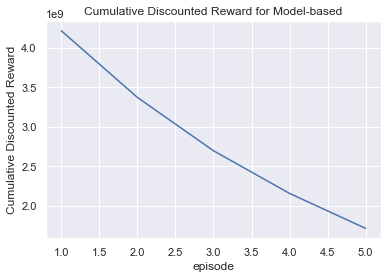

In [203]:
model_agent.plot_cumulative_discounted_rewards()

In [236]:
h = model_agent.history

In [237]:
h.head(10)

,date,ticker,rewards,actions,returns,prices,episode
0,2014-01-06,MMM,0.0,0,0.0,137.630005,1
1,2014-01-07,MMM,0.0,0,0.0,137.649994,1
2,2014-01-08,MMM,0.0,0,0.0,136.630005,1
3,2014-01-09,MMM,0.0,0,0.0,136.449997,1
4,2014-01-10,MMM,0.0,0,0.0,136.179993,1
5,2014-01-13,MMM,0.0,0,0.0,134.679993,1
6,2014-01-14,MMM,0.0,0,0.0,137.410004,1
7,2014-01-15,MMM,0.0,0,0.0,138.440002,1
8,2014-01-16,MMM,0.0,0,0.0,138.160004,1
9,2014-01-17,MMM,0.0,0,0.0,137.309998,1


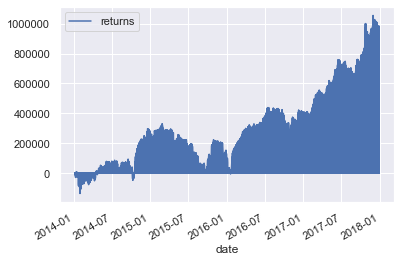

In [238]:
h[h.ticker == 'MMM'].plot('date', 'returns')

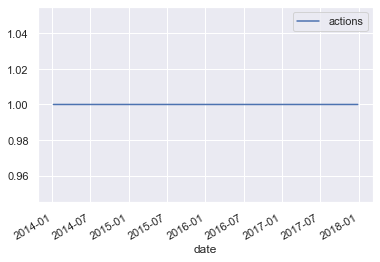

In [219]:
h[h.ticker == 'MMM'].plot('date', 'actions')

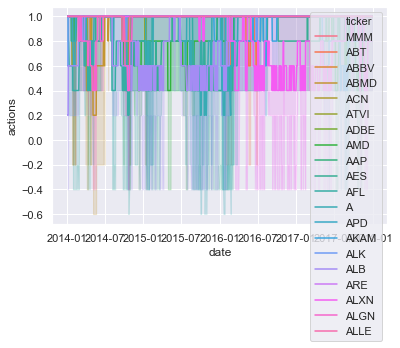

In [222]:
sns.lineplot('date', 'actions', data=h, hue='ticker')

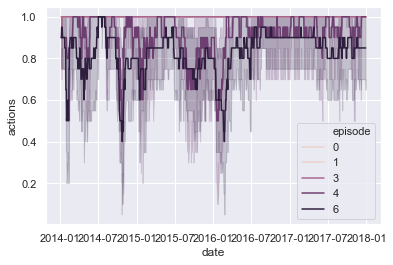

In [223]:
sns.lineplot('date', 'actions', data=h, hue='episode')

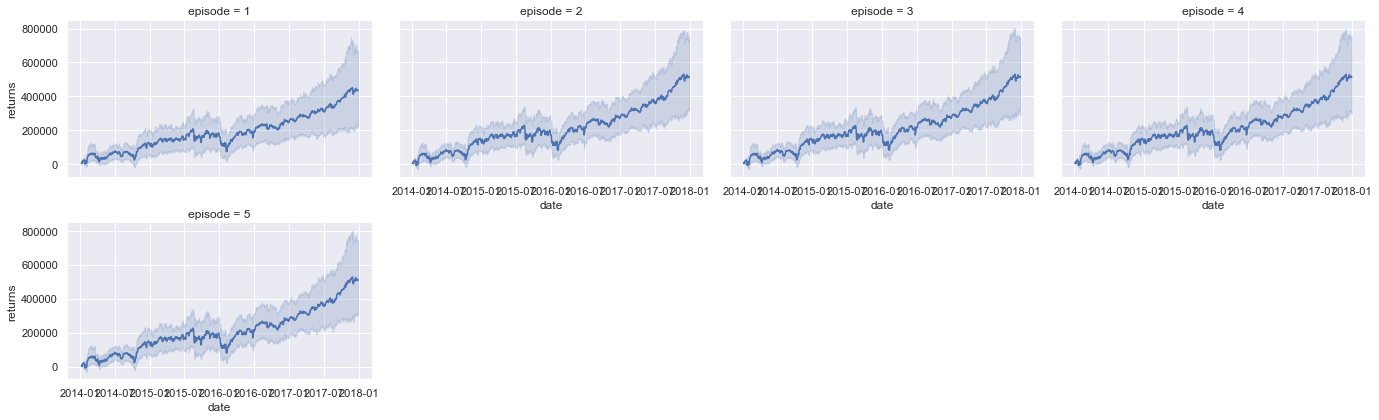

In [239]:
q = sns.FacetGrid(h, col='episode', col_wrap=4, aspect=1.61)
q = q.map(sns.lineplot, 'date', 'returns')

In [228]:
import matplotlib.dates as mdates
xformatter = mdates.DateFormatter("%m/%y")
q.axes[0].xaxis.set_major_formatter(xformatter)

In [300]:
class ModelBased_NoText_Agent(BaseAgent):
    LR = 0.001  # NN optimizer learning rate
    BATCH_SIZE = 16  # Q-learning batch size
    TARGET_UPDATE = 100  # frequency of target update
    BUFFER_SIZE = 256  # capacity of the replay buffer

    def __init__(self):
        super().__init__()
        self.name = "Model-based"
        self.R = QNetwork()
        self.T = TransitionModel()
        self.Q = QNetwork()
        
        if use_cuda:
            self.R.cuda()
            self.T.cuda()
            self.Q.cuda()
        
        self.R_opt = optim.Adam(self.R.parameters())
        self.T_opt = optim.Adam(self.T.parameters())
        self.Q_opt = optim.Adam(self.Q.parameters())
        self.memory = ReplayMemory(BUFFER_SIZE)
        self.BATCH_SIZE = 2

    def run_episode(self, environment):
        """
            Takes an env, and trains the agent until the environment
            reaches a terminal state (ie the training window is complete).
            Must return environment.close()
        """
        state = environment.reset()
        self.steps_done = 0
        while True:
            state_tensor = FloatTensor([state])
            position = self.Q.sample_from_softmax_policy(state_tensor)
            action = position + 1
            next_state, reward, done, _ = environment.step(position.item())
            self.memory.push(
                (
                    state_tensor,
                    action,
                )
            )
            self.learn(state_tensor, action, next_state, reward)
            state = next_state
            self.steps_done += 1
            if done:
                break
        history = environment.close()
        return history

    def learn(self, state_tensor, action, next_state, reward):
        # update Transition
        next_state_from_seq = FloatTensor([next_state[-5:]])
        predicted_next_state= self.T(state_tensor)
        T_loss = F.smooth_l1_loss(predicted_next_state, next_state_from_seq)
        self.T_opt.zero_grad()
        T_loss.backward()
        self.T_opt.step()
        
        # update Reward
        predicted_reward = self.R(state_tensor).gather(1, action).squeeze(1)
        reward_tensor = FloatTensor([reward])
        R_loss = F.smooth_l1_loss(predicted_reward, reward_tensor)
        self.R_opt.zero_grad()
        R_loss.backward()
        self.R_opt.step()
        
        # update Q-net
        q = self.Q(state_tensor).gather(1, action).squeeze(0)
        next_state_tensor = FloatTensor([next_state])
        future_q = reward + self.gamma * self.Q(next_state_tensor).max(dim=1)[0]
        Q_loss = F.smooth_l1_loss(q, future_q.detach())
        self.Q_opt.zero_grad()
        Q_loss.backward()
        self.Q_opt.step()
        
        if len(self.memory) <= self.BATCH_SIZE:
            return
        
        # random transition batch is taken from experience replay memory
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch_state, batch_action = zip(
            *transitions
        )
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        
        batch_next_state = self.T.next_state(batch_state).detach()
        batch_reward = self.R(batch_state).detach().gather(1, batch_action).squeeze(1)

        # current Q values are estimated by NN for all actions
        current_q_values = self.Q(batch_state).gather(1, batch_action).squeeze()
        simulated_q_values = self.Q(batch_next_state).max(dim=1)[0]
        future_q = batch_reward + self.gamma * simulated_q_values
        simulated_q_loss = F.smooth_l1_loss(current_q_values, future_q.detach())
        self.Q_opt.zero_grad()
        simulated_q_loss.backward()
        self.Q_opt.step()


    def train(self, env_mode="train", num_tickers=5, episode_per_ticker=3):
        """
            Trains the agent for num_episodes episodes, looping over the approved
            list of tickers (filtered by num_tickers). This is a convenience function.
        """
        num_tickers = min(num_tickers, len(self.filtered_tickers))
        self.history = pd.DataFrame()
        
        for j in range(num_tickers):
            ticker = self.filtered_tickers[j % num_tickers]
            env = TradingEnv(ticker=ticker, mode=env_mode)
            for i in tqdm(range(episode_per_ticker)):    
                history = self.run_episode(env)
                history["ticker"] = ticker
                history["episode"] = i + 1
                self.history = pd.concat((self.history, history))
        self.history = self.history.reset_index("Date", drop=True)

In [301]:
model_without_text = ModelBased_NoText_Agent()
# e_notext = TradingEnv()
# model_without_text.run_episode(e_notext)

In [302]:
model_without_text.train()

100%|██████████| 3/3 [00:09<00:00,  3.12s/it]


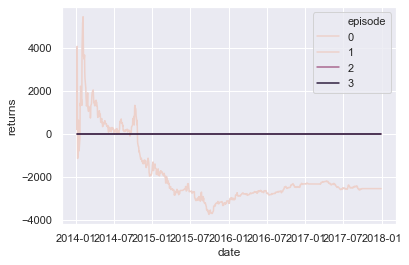

In [303]:
h = model_without_text.history
sns.lineplot('date', 'returns', data=h[h.ticker == 'MMM'], hue='episode')

In [282]:
h.ticker.unique()

array(['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP',
       'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN',
       'ALGN', 'ALLE'], dtype=object)

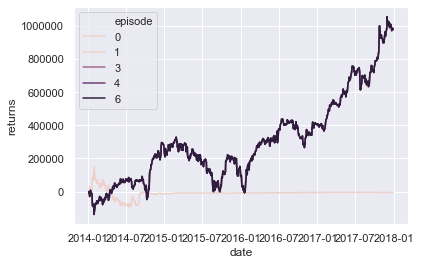

In [281]:
sns.lineplot('date', 'returns', data=h[h.ticker == 'MMM'], hue='episode')

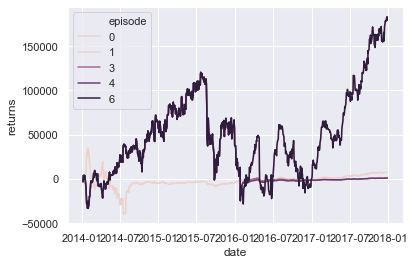

In [283]:
sns.lineplot('date', 'returns', data=h[h.ticker == 'ABT'], hue='episode')